#### Initial imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### Set processing parameters

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
USE_PARALLEL = False

### Prep lists of input files

In [3]:
from glob import glob
import re
import pandas as pd
from random import sample, seed

In [4]:
encoder_list = ['resnet34']
avail_suffix = ['rgb', 'dsm', 'ndvi', 'tpi']

In [5]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set directories for training data and labels
DATA_FOLDER = './cnn_train_images_2cm/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels_2cm/{}_labels.tif'

# set parameters for each resolution
res_dict = {
    5: {'min_factor': 3,
        'max_factor': 6},
    10: {'min_factor': 1,
        'max_factor': 4},
    15: {'min_factor': 1,
        'max_factor': 3},
    30: {'min_factor': 1,
        'max_factor': 2}
}

In [6]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [7]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[2:]) for y in all_ids]))

In [8]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.3)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [9]:
tile_ids = df_tiles[(df_tiles['trainer'] != 'Nick') &
                    (df_tiles['Digitize'] == 1)].apply(lambda x: '_'.join([x.Pasture, x.Tile]), axis=1)
#all_tiles#
[x for x in all_tiles if x not in tile_ids.to_list()]

[]

In [10]:
[x for x in tile_ids.to_list() if x not in all_tiles]

[]

### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
from skimage.transform import resize

In [12]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)


### Augmentations

In [13]:
import albumentations as albu
import random

In [14]:
def get_training_augmentation(min_factor, max_factor):
    win_size = 32 * random.randint(min_factor, max_factor)
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomCrop(height=win_size, width=win_size, always_apply=True),

        #albu.GaussNoise(p=0.2, var_limit=1.0),
        #albu.Perspective(p=0.5),

        #albu.OneOf(
        #    [
        #        #albu.CLAHE(p=1), # required int8 images
        #        albu.RandomBrightnessContrast(p=1),
        #        #albu.RandomGamma(p=1),
        #        #albu.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=(3, 7), p=1),
                albu.MotionBlur(blur_limit=(3, 7), p=1),
            ],
            p=0.25,
        ),
    ]
    return albu.Compose(train_transform)

### Create preprocessing function from training data stats

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn as nn
import gc

In [16]:
mod_list = ['deeplabplus']
inputs_list = [['rgb', 'dsm', 'ndvi'], 
               ['rgb', 'dsm'],
               ['rgb', 'ndvi'],
               ['dsm', 'tpi'], 
               ['rgb'],
              ]

In [17]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #'cuda'# 'cpu'# 
CLASSES = ['burrow']

In [18]:
print(DEVICE)

cuda:0


In [19]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

### Check that augmentation and normalization are working as expected

In [20]:
res = 5

In [21]:
# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [22]:
print(image_stats)

{'rgb': {'min': 0.0, 'max': 255.0}, 'ndvi': {'min': 0.0, 'max': 1.0}}


torch.Size([3, 128, 128])


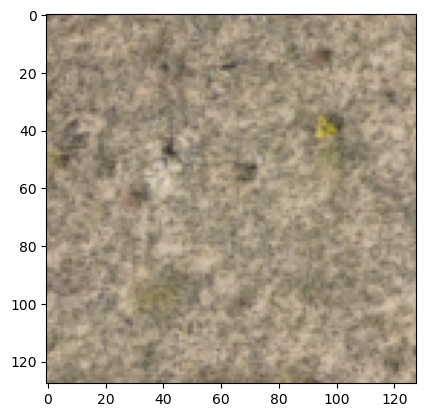

In [23]:
suffix_list = ['rgb']
train_dataset = Dataset(
        train_ids,
        suffix_list,
        re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
        re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
        augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                               res_dict[res]['max_factor']),
        preprocessing=True,
        classes=CLASSES)
i = 21
img = train_dataset[i]
print(img[0].shape)
try:
    plt.imshow(img[0].cpu().numpy().squeeze())
except TypeError:
    plt.imshow(img[0].cpu().numpy().transpose(1, 2, 0))

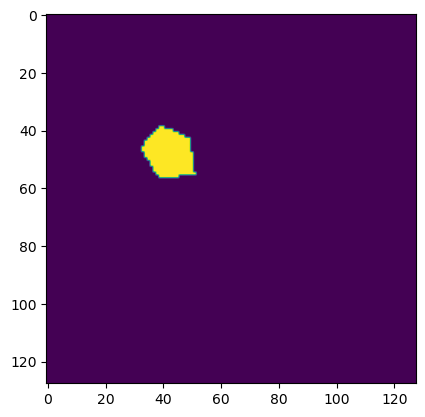

In [24]:
plt.imshow(img[1].cpu().numpy().squeeze())

In [25]:
for res in res_dict:
#res = 5
    print('\n\n----------------------------------------------------------')
    print('Running all models for RESOLUTION = ' + str(res) + ' cm')

    ### Create and train model

    for mod in mod_list:
        print('----------------------------------------------------------')
        print('Now running model: ' + mod)
        print('----------------------------------------------------------')
        outDIR = './cnn_results_' + mod + '_' + str(res) + 'cm/'
        if not os.path.exists(outDIR):
            os.mkdir(outDIR)
        for suffix_list in inputs_list:
            print('----------------------------------------------------------')
            print(suffix_list)
            if os.path.exists(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt'):
                print('skipping - already trained.')
                continue
            else:
                train_dataset = Dataset(
                    train_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    augmentation=get_training_augmentation(res_dict[res]['min_factor'],
                                                           res_dict[res]['max_factor']),
                    preprocessing=True,
                    classes=CLASSES)

                valid_dataset = Dataset(
                    valid_ids,
                    suffix_list,
                    re.sub('2cm', str(res) + 'cm', DATA_FOLDER),
                    re.sub('2cm', str(res) + 'cm', LABEL_FOLDER),
                    preprocessing=True,
                    classes=CLASSES)


                train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False,
                                          drop_last=True, num_workers=6, pin_memory=False)
                valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

                # create segmentation model with pretrained encoder
                if mod == 'deeplabplus':
                    model = smp.DeepLabV3Plus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'fpn':
                    model = smp.FPN(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'manet':
                    model = smp.MAnet(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                elif mod == 'unetplus':
                    model = smp.UnetPlusPlus(
                        encoder_name=ENCODER, 
                        encoder_weights=ENCODER_WEIGHTS, 
                        classes=len(CLASSES), 
                        activation=ACTIVATION,
                        in_channels=train_dataset[0][0].shape[0],
                    )
                else:
                    print('ERROR: model "' + mod + '" not found!')
                    break

                if USE_PARALLEL:
                    model = nn.DataParallel(model)

                preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

                # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
                # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

                loss = smp.losses.MCCLoss()
                loss.__name__ = 'mccloss'
                metrics = [
                    utils.metrics.IoU(threshold=0.5),
                    utils.metrics.Accuracy(threshold=0.5),
                    utils.metrics.Precision(threshold=0.5),
                    utils.metrics.Recall(threshold=0.5),
                    utils.metrics.Fscore(threshold=0.5)
                ]

                optimizer = torch.optim.Adam([ 
                    dict(params=model.parameters(), lr=0.0001),
                ])

                # create epoch runners 
                # it is a simple loop of iterating over dataloader`s samples
                train_epoch = utils.train.TrainEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    optimizer=optimizer,
                    device=DEVICE,
                    verbose=True,
                )

                valid_epoch = utils.train.ValidEpoch(
                    model, 
                    loss=loss, 
                    metrics=metrics, 
                    device=DEVICE,
                    verbose=True,
                )

                # train model for up to 60 epochs

                max_score = 0
                max_score_train = 0
                no_improve = 0

                for i in range(1, 61):

                    print('\nEpoch: {}'.format(i))
                    train_logs = train_epoch.run(train_loader)
                    valid_logs = valid_epoch.run(valid_loader)
                    valid_logs['fscore_old'] = valid_logs['fscore']
                    beta = 1.0
                    valid_logs['fscore'] = ((1 + beta) * valid_logs['recall'] * valid_logs['precision']) / (valid_logs['recall'] + beta * valid_logs['precision'])
                    train_logs['fscore_old'] = train_logs['fscore']
                    beta = 1.0
                    train_logs['fscore'] = ((1 + beta) * train_logs['recall'] * train_logs['precision']) / (train_logs['recall'] + beta * train_logs['precision'])                # do something (save model, change lr, etc.)
                
                    # do something (save model, change lr, etc.)
                    if max_score < valid_logs['fscore']:
                        max_score = valid_logs['fscore']
                        max_score_train = train_logs['fscore']
                        torch.save(model, outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm.pth')
                        valid_logs['best_epoch'] = i
                        valid_logs['resolution'] = float(res)
                        best_valid_logs = valid_logs.copy()
                        print('Model saved!')
                        no_improve = 0
                    else:
                        no_improve += 1
                        print('No improvement in ' + str(no_improve) + ' epochs. Model not saved.')

                    if i > 15:
                        if no_improve >= 5:
                            if (train_logs['fscore'] - max_score_train) < 0.05:
                                print('More than 5 epochs without validation improvement while learning rate <= 1e-5 and training improvement < 0.05...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                            elif (train_logs['fscore'] - max_score_train) < 0.15 and no_improve == 15:
                                print('15 epochs without validation improvement while learning rate <= 1e-5...ending training')
                                with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))
                                break
                    if i == 60:
                        with open(outDIR + 'best_model_' + '_'.join(suffix_list) + '_' + str(res) + 'cm_validation.txt','w') as data: 
                                    data.write(str(best_valid_logs))

                    if i%15 == 0:
                        no_improve = 0
                        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
                        print('Decrease decoder learning rate by factor of 10')

                del model, train_epoch, valid_epoch
                gc.collect()
                torch.cuda.empty_cache()



----------------------------------------------------------
Running all models for RESOLUTION = 5 cm
----------------------------------------------------------
Now running model: deeplabplus
----------------------------------------------------------
----------------------------------------------------------
['rgb', 'dsm', 'ndvi']
skipping - already trained.
----------------------------------------------------------
['rgb', 'dsm']
skipping - already trained.
----------------------------------------------------------
['rgb', 'ndvi']
skipping - already trained.
----------------------------------------------------------
['dsm', 'tpi']
skipping - already trained.
----------------------------------------------------------
['rgb']
skipping - already trained.


----------------------------------------------------------
Running all models for RESOLUTION = 10 cm
----------------------------------------------------------
Now running model: deeplabplus
--------------------------------------------

In [26]:
print('All processing complete!')

All processing complete!
